In [1]:
import sys
sys.path.append('..')

from src import Environment, Agent
from src.agents import FSVI_Agent
from src.simulation import run_test, SimulationHistory

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import cupy as cp

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

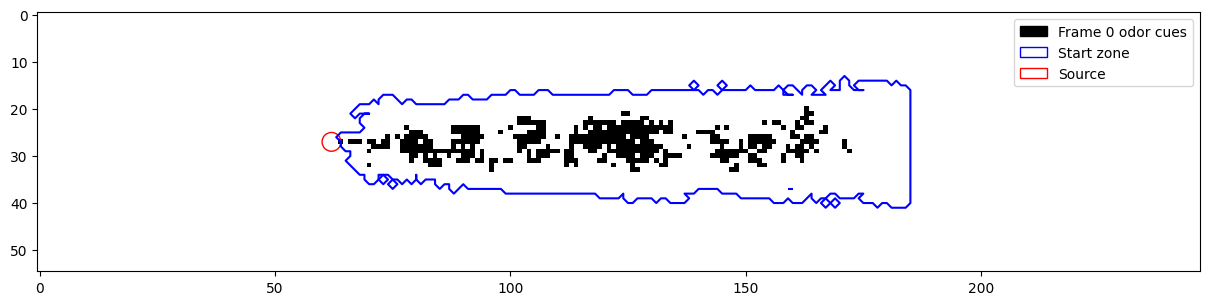

In [3]:
env = Environment(data="G:\\My Drive\\Documents\\Universita di Genova\Pimlb work\\nose_data_27_123.npy",
                  source_position=[13, 0],
                  source_radius=2,
                  margins=[14, 62],
                  boundary_condition='wrap_vertical',
                  start_zone='odor_present',
                  odor_present_treshold=3e-6)

env.plot()

In [4]:
env.save(force=True)

Environment saved to: ./Env-55_247-edge_wrap_vertical-start_odor_present-source_27_62_radius2


In [8]:
ag = FSVI_Agent(env)

[04/19/2024, 12:27:43] Instantiation of MDP Model:
[04/19/2024, 12:27:43] - 13585 states
[04/19/2024, 12:27:43] - 4 actions
[04/19/2024, 12:27:43] - At most 1 reachable states per state-action pair
[04/19/2024, 12:27:43] - Starting generation of transitions table
[04/19/2024, 12:27:43]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[04/19/2024, 12:27:43]     > Done in 0.000s
[04/19/2024, 12:27:43] - Generation of state grid
[04/19/2024, 12:27:43] - Generating start probabilities table
[04/19/2024, 12:27:43] - Starting computation of reachable state probabilities from transition data
[04/19/2024, 12:27:43]     > Done in 0.000s

[04/19/2024, 12:27:43] POMDP particular parameters:
[04/19/2024, 12:27:43] - 3 observations
[04/19/2024, 12:27:43] - Starting of transitional observations for reachable states table
[04/19/2024, 12:27:43]     > Done in 0.003s
[04/19/2

In [9]:
hist = ag.train(expansions=10, force=True)

print(hist)

[04/19/2024, 12:27:43] MDP_policy, not provided. Solving MDP with Value Iteration...


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 13585-state, 4-action
  - Converged in 918 iterations and 0.8614 seconds
  - Took on average 0.0009s per iteration


Expansions:   0%|          | 0/10 [00:00<?, ?it/s]

[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


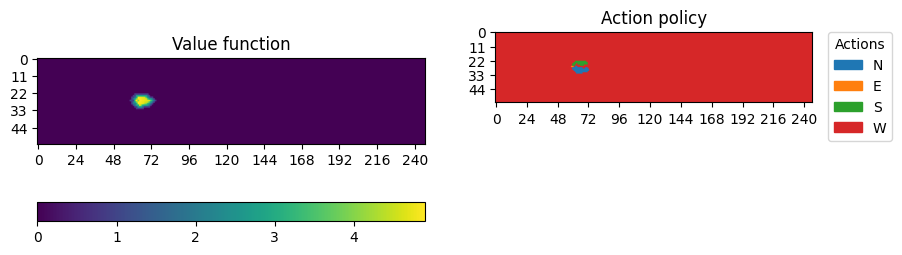

In [10]:
ag.value_function.plot()

In [8]:
ag.save(force=True, save_environment=True)

Environment saved to: ./Agent-FSVI_Agent-tresh_3e-trained_04172024_175117/Env-55_247-edge_wrap_vertical-start_odor_present-source_27_62_radius2
Agent saved to: ./Agent-FSVI_Agent-tresh_3e-trained_04172024_175117


In [11]:
hist = run_test(n=100, agent=ag, time_shift=2400, use_gpu=True)

[03/20/2024, 18:37:02] Sending Model to GPU...
[03/20/2024, 18:37:02]     > Done in 0.172s


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 10.691s:
Simulations reached goal: 99/100 (1 failures) (99.00%)
	- Average step count: 85.68 (Successfull only: 84.54545454545455)
	- Extra steps: 11.77 (Successful only: 10.343434343434344)
	- Average discounted rewards (ADR): 0.462 (Successfull only: 0.465) (discount: 0.99)
	- Tmin/T: 0.882 (Successful only: 0.889)


In [12]:
hist.save()

Simulations saved to: ./Simulations-s_55_247-n_100-horizon_198-03202024_183708.csv


In [13]:
hist2 = SimulationHistory.load_from_file('./Simulations-s_55_247-n_100-horizon_198-03192024_181337.csv')

Environment "55_247-edge_wrap_vertical-start_odor_present-source_27_62_radius2" loaded from memory


Agent used is not tracked


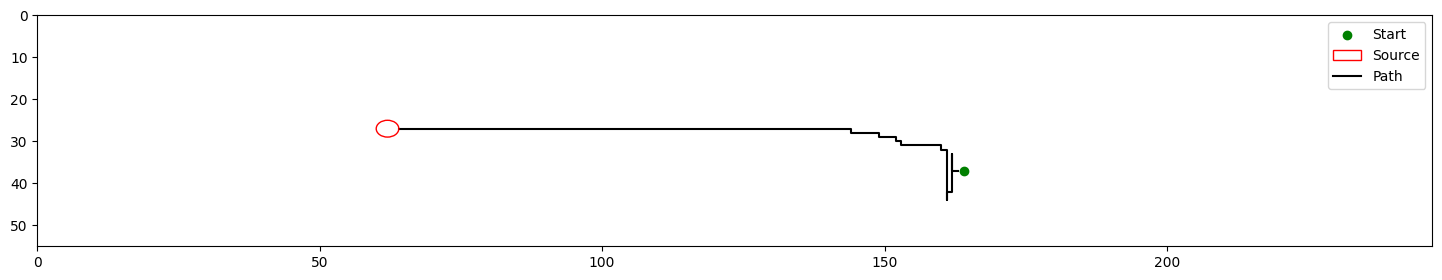

In [16]:
hist2.plot(10)